In [5]:
import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.special import iv
from scipy.optimize import minimize

## Contents
   - [Mouvement Brownien](#sec1)
      - [Intervalle de confiance](#sec1.2)
      - [Test d'Hypothèses](#sec1.3)
   - [Mouvement Brownien Géométrique](#sec2)

<a id='sec1'></a>
# Mouvement Brownien

Let us simulate some Brownian paths.    
Rappelons les propriétés principales du Mouvement Brownien $\{X_t\}_{t\geq 0}$ : 
- $X_{0} = 0$.
- Les incréments sont indépendants
- C'est une martingale
- Les trajectoires sont continues mais différentiables en aucun point
- $X_t - X_s \sim \mathcal{N}(0,t-s)$ pour $t\geq s \geq 0$.

Pour plus d'infos, consultez [wiki](https://en.wikipedia.org/wiki/Brownian_motion).

Dans le cadre de la simulation, nous allons simuler les incréments du Brownien de la manière suivante : 

$$ X_{t_i+\Delta t} - X_{t_i} = \Delta X_i \sim \mathcal{N}(\mu \Delta t,\, \sigma^2 \Delta t). $$

Le processus à la date T est alors donné par  $X_T = \sum_i \Delta X_i$ eet suit la distribution suivante par indépendance des incréments : 

$$ X_T \sim \mathcal{N}(\mu T,\, \sigma^2 T). $$

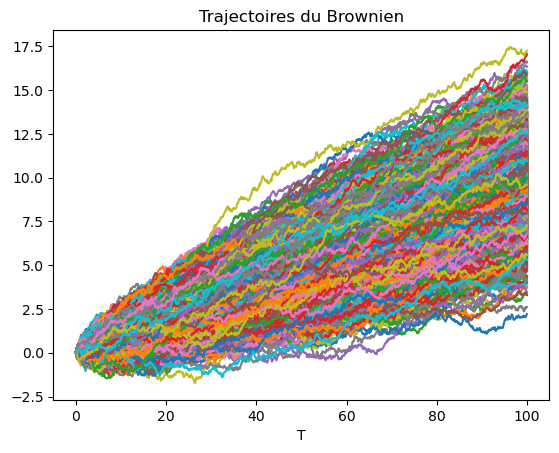

In [25]:
#scipy.stats uses numpy.random to generate its random numbers
np.random.seed(seed=42)   

paths=4000              # number of paths
steps=1000             # number of time steps

mu = 0.1               # drift 
sig = 0.2              # diffusion coefficient or volatility 
T = 100                
T_vec, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths,1))        # each path starts at zero
increments = ss.norm.rvs(loc=mu*dt, scale=np.sqrt(dt)*sig, size=(paths,steps-1))

X = np.concatenate((X0,increments), axis=1).cumsum(1)

plt.plot(T_vec,X.T); plt.title("Trajectoires du Brownien"); plt.xlabel("T")
plt.show()

In [26]:
X_end = X[:,-1]
print("Espérance de X à la date T: {:.4f}".format(X_end.mean()) )
print("Ecart type de X à la date T T: {:.4f}".format(X_end.std(ddof=1)) )

# On retrouve les valeurs attendues

Espérance de X à la date T: 9.9827
Ecart type de X à la date T T: 1.9964


<a id='sec1.2'></a>
## Intervalles de Confiance


On souhaite dans cette partie associer un intervalle de confiance à chaque paramètre estimé.
On veut trouver un intervalle de valeurs du paramètre estimé avec un niveau de confiance donné de la forme $(1-\alpha)100\%$, avec $0<\alpha<1$. 

On redonne ici quelques définitions de base :

Considérons $X_i$ i.i.d, pour $1\leq i \leq n$, avec $\mathbb{E}[X_i]=\mu$ et  $Var[X_i] = \sigma^2$.    
On note $\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i$.
- $\bar{X}$ a une moyenne de: $\mathbb{E}[\bar{X}] = \frac{1}{n}\sum_{i=1}^n \mathbb{E}[X_i] = \mu$.
- $\bar{X}$ a une variance de : $Var[\bar{X}] = \frac{1}{n^2} Var[\sum_{i=1}^n X_i] = \frac{1}{n^2} \sum_{i=1}^n Var[X_i] = \frac{\sigma^2}{n}$.
- Théorème Central Limite: $$ Z_n = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} \underset{n\to \infty}{\to} Z \sim \mathcal{N}(0,1) $$

##### Variables Normales
Pour $Z \sim \mathcal{N}(0,1)$, on note $z_{\alpha/2}$ la valeur telle que :

$$ \mathbb{P}(Z< -z_{\alpha/2}) = \mathbb{P}(Z > z_{\alpha/2}) = \alpha/2 $$

Posons $X_i \sim \mathcal{N}(\mu,\sigma^2)$. **Suppons $\sigma$ inconnu**.

On a :
$\sum_{i=1}^n X_i \sim \mathcal{N}(n\mu,n\sigma^2)$, d'où $\bar{X} \sim \mathcal{N}(\mu,\frac{\sigma^2}{n})$. 
On a alors : $Z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} \sim \mathcal{N}(0,1) $.     

On peut écrire :

$$ \begin{aligned}
(1 - \alpha) &= \mathbb{P} \biggl( -z_{\alpha/2} < \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} < z_{\alpha/2} \biggr) \\
             &= \mathbb{P} \biggl(\bar{X} - z_{\alpha/2} \frac{\sigma}{\sqrt{n}} <  \mu < \bar{X} + z_{\alpha/2} \frac{\sigma}{\sqrt{n}} \biggr)
\end{aligned} $$

Alors, le $(1 - \alpha)100\%$ intervalle de confiance pour $\mu$ est :

$$ \biggr[ \bar{x} - z_{\alpha/2} \frac{\sigma}{\sqrt{n}} \, , \; \bar{x} + z_{\alpha/2} \frac{\sigma}{\sqrt{n}} \biggr] $$

where $\bar{x}$ est une réalisation de $\bar{X}$.    

En général, on calcule l'intervalle de confiance à $95\%$
Pour un intervalle de confiance à $95\%$ , $1-\alpha = 0.95$, donc $\alpha/2 = 0.025$, et  $z_{0.025} = 1.96$.

Posons $X_i \sim \mathcal{N}(\mu,\sigma^2)$. **On suppose $\sigma$ inconnu**.

We can consider instead the [sample variance](https://en.wikipedia.org/wiki/Variance#Sample_variance) (unbiased version, $\mathbb{E}[S^2] = \sigma^2$):

$$ S^2 = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2 $$
et la statistique
$$ T = \frac{\bar{X} - \mu}{\frac{S}{\sqrt{n}}} $$

On rappelle:
- $\bar{X}$ et $S^2$ sont indépendants.
- $S^2 \sim \frac{\sigma^2}{n-1} \chi^2_{n-1}.$
- $T \sim t_{n-1}$ (**student t distribution**) [wiki]().

On peut donc montrer un intervalle de confiance pour la moyenne en utilisant l'estimateur **de $\sigma$ donné** :

$$ \biggr[ \bar{x} - t_{\alpha/2,n-1} \frac{s}{\sqrt{n}} \, , \; \bar{x} + t_{\alpha/2,n-1} \frac{s}{\sqrt{n}} \biggr] $$

où $\bar{x}$ et $s$ sont des réalisations de $\bar{X}$ et $S$.    




In [52]:
print("L'espérance de la moyenne est : {:.6f}".format(X_end.mean()) )
print("L'intervalle de confiance à 95% est : ", ss.t.interval(0.95, paths-1, loc=X_end.mean(), scale=ss.sem(X_end)) )

L'espérance de la moyenne est : 9.982654
L'intervalle de confiance à 95% est :  (9.911246240121717, 10.05406238361326)


In [53]:
s2 = X_end.var(ddof=1)   # unbiased sample variance
AA = s2 * (paths-1) 
print("L'estimation de l'écrt-type est : {:.6f}".format(X_end.std(ddof=1)) )
print("L'intervalle de confiance à 95% est : ", \
      np.sqrt(AA / ss.chi2.ppf(0.975, df=paths-1)), np.sqrt(AA / ss.chi2.ppf(0.025, df=paths-1)) )

L'estimation de l'écrt-type est : 1.996432
L'intervalle de confiance à 95% est :  1.373216233298155 3.644706629890652


##### Sometimes the confidence interval fails!

On a choisi un intervalle de confiance à $95\%$ donc on est censés échouer 5% du temps

On teste donc cette propriété en regardant donc l'erreur sur l'estimation de la moyenne qui doit valoir $\mu T=1$. On répète 100 fois l'expérience en modifiant la graine de la simulation des gaussiens


In [62]:
for n in range(100):
    np.random.seed(seed=n)
    XT = ss.norm.rvs(loc=mu*T, scale=np.sqrt(T)*sig, size=paths)
    low = ss.t.interval(0.95, paths-1, loc=XT.mean(), scale=ss.sem(XT))[0]
    high = ss.t.interval(0.95, paths-1, loc=XT.mean(), scale=ss.sem(XT))[1]
    if (mu*T < low) or (mu*T > high):
        print("seed:", n, '\n', mu*T, "is not contained in ", (low.round(4),high.round(4)) )

seed: 0 
 1.0 is not contained in  (1.0056, 1.928)
seed: 9 
 1.0 is not contained in  (0.4569, 0.8886)
seed: 15 
 1.0 is not contained in  (0.3847, 0.9675)
seed: 16 
 1.0 is not contained in  (0.394, 0.9934)
seed: 27 
 1.0 is not contained in  (1.0192, 1.5206)
seed: 84 
 1.0 is not contained in  (0.3154, 0.9633)
seed: 89 
 1.0 is not contained in  (0.4245, 0.9462)


**On voit 6 erreurs!!**

Les paramètres peuvent être estimés en utilisant la bibliothèque scipy :

In [56]:
param = ss.norm.fit(X_end)
print("Paramètres estimées : ", param) # these are MLE parameters


Paramètres estimées :  (9.982654311867488, 1.9961824533945993)


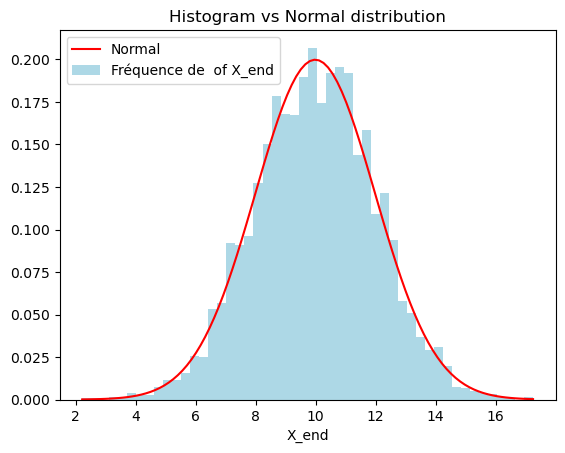

In [59]:
x = np.linspace(X_end.min(), X_end.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

plt.plot(x, pdf_fitted, color='r', label="Normal")
plt.hist(X_end, density=True, bins=50, facecolor="LightBlue", label="Fréquence de  of X_end")
plt.legend(); plt.title("Histogram vs Normal distribution"); plt.xlabel("X_end")
plt.show()

<a id='sec1.3'></a>
## Tests d'Hypothèses


On va s'intéresser ici uniuement à la  **p-value**.
C'est la probabilité d'obtanie des valeurs dans la distribution plus extrêmes que celle dans la data, en assumant que $H_0$ est vraie.
Elle se réfère comme le plus petit niveau $\alpha$ qui permet de rejeter l'hypothèse nulle

Ici, on s'intéresse à quelques "tests classiques" pour tester la normalité de $X_T$
- **Shapiro-Wilk**, [doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)      
  L'hypothèse nulle $H_0$ est que la data suit une distribution normale   
- **Jarque-Bera** [doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html)     
  L'hypothèse nulle $H_0$ est que la data suit une distribution normale   
  It returns the test statistics and the p-value. 
- **Kolmogorov-Smirnov**, [doc](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html)    
  Ce test permet de comparer 2 distributions     
  L'hypothèse nulle indique que les 2 distributions sont égales


On peut également visualier les  **Q-Q plot**.

- Shapiro - Wilk:

In [39]:
ss.shapiro(X_end)   

ShapiroResult(statistic=0.9995088577270508, pvalue=0.4110822081565857)

Vu la valeur de la p-value, on ne peut pas rejeter $H_0$

- Jarque - Bera:

In [60]:
ss.jarque_bera(X_end)  

SignificanceResult(statistic=1.8821352125475082, pvalue=0.39021102116710205)

Vu la valeur de la p-value, on ne peut pas rejeter $H_0$

- Kolmogorov - Smirnov:

In [61]:
ss.kstest(X_end, lambda x: ss.norm.cdf(x,loc=10, scale=2) )

KstestResult(statistic=0.010299978780936525, pvalue=0.7857293135081154, statistic_location=8.92058869860379, statistic_sign=1)

Vu la valeur de la p-value, on ne peut pas rejeter $H_0$

- Q-Q plot:

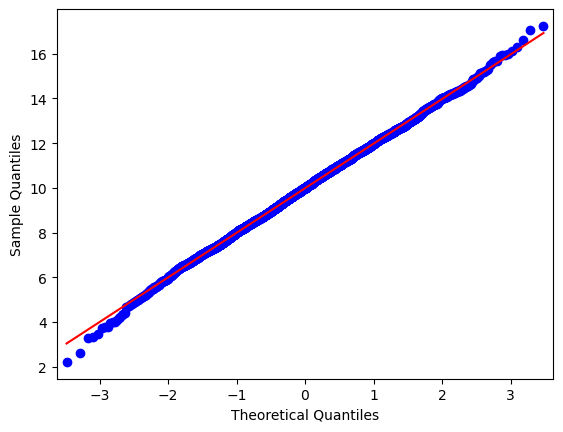

In [45]:
qqplot(X_end, line='s');  plt.show()

<a id='sec2'></a>
# Mouvement Brownien Géométrique

Le mouvement Brownien géométrique suite l'équation différentielle stochastique suivante:


$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Par application du lemme d'Itô, on peut montrer que la solution de cette équation différentielle est : 

$$ S_t = S_0 e^{(\mu-\frac{1}{2}\sigma^2)t + \sigma W_t} $$

In [34]:
np.random.seed(seed=42) 
mu = 0.1
sig = 0.2
T = 10
N = 10000 
S0 = 1

W = ss.norm.rvs( loc=(mu - 0.5 * sig**2)*T, scale=np.sqrt(T)*sig, size=N )
S_T = S0 * np.exp(W)

In [35]:
param_LN = ss.lognorm.fit(S_T)
print("Paramètres fittés : ", param_LN)
print("Shape: ", sig*np.sqrt(T) )
print("Scale: ", np.exp((mu - 0.5 * sig**2)*T))

Paramètres fittés :  (0.6335031590210367, -0.0031793067974526315, 2.226428161130303)
Shape:  0.632455532033676
Scale:  2.225540928492468


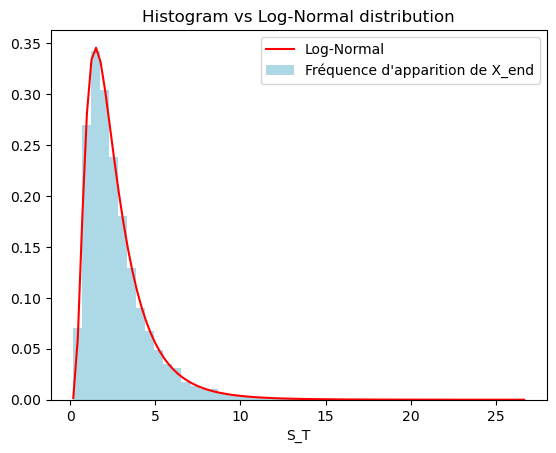

In [36]:
x = np.linspace(S_T.min(), S_T.max(), 100)
pdf_LN_fitted = ss.lognorm.pdf(x, *param_LN)

plt.plot(x, pdf_LN_fitted, color='r', label="Log-Normal")
plt.hist(S_T, density=True, bins=50, facecolor="LightBlue", label="Fréquence d'apparition de X_end")
plt.legend(); plt.title("Histogram vs Log-Normal distribution"); plt.xlabel("S_T")
plt.show()

##### Estimation de Paramètres

On utilise le fait que $S_T$ suit une loi log normale :
$$\log S_T \sim \mathcal{N} \biggl( (\mu-\frac{1}{2}\sigma^2)T, \sigma^2 T \biggr)$$

Maintenant, il nous suffit d'estimer les paramètres d'une gaussienne

In [37]:
std_S = np.std(np.log(S_T), ddof=0 )/np.sqrt(T)
mu_S = np.mean(np.log(S_T))/T + 0.5 * std_S**2

print("Volatilité : ", std_S.round(6))
print("Tendance : ", mu_S.round(6))

Volatilité :  0.200682
Tendance :  0.100002


##### Simulation de Trajectoires

Pour simuler des trajectoires du Mouvement Brownien Géométrique, il suffit comme nous l'avons vu de simuler des trajectoires de mouvement brownien avec un ajustement de la tendance et ensuite de passer à l'exponentielle par définition 



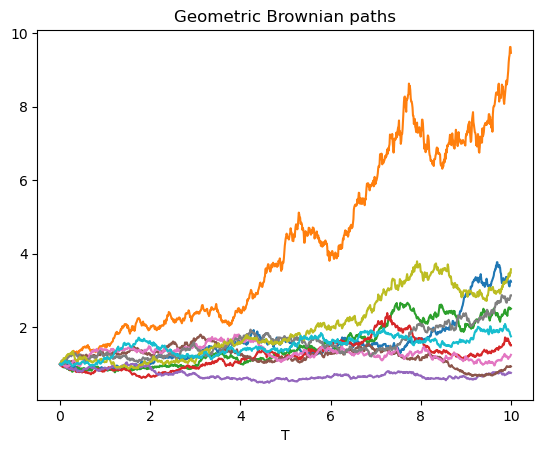

In [38]:
np.random.seed(seed=42) 
paths=10              # number of paths
steps=1000            # number of time steps
T = 10                
T_vec, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths,1))        # each path starts at zero
W = ss.norm.rvs( (mu - 0.5 * sig**2)*dt, np.sqrt(dt)*sig, (paths,steps-1))
X = np.concatenate((X0,W), axis=1).cumsum(1)

S_T = np.exp(X)
plt.plot(T_vec, S_T.T ); plt.title("Geometric Brownian paths"); plt.xlabel("T")
plt.show()